In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [40]:
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'

In [41]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [42]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'mvpa2')

In [43]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [44]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 1), 'features')

def load_subject_time_feature(subj, time_steps, normalize=True):
    feature_loaded = []
    subj_result_folder = os.path.join(DEFAULT_FEATURE_FOLDER, f'{int(subj)}')
    subj_combined_feature_path = os.path.join(subj_result_folder, 'combined')
    for tid in time_steps:
        loaded = np.load(os.path.join(subj_combined_feature_path, f'{tid}.npy'))
        feature_loaded.append(loaded)
    features = np.mean(feature_loaded, axis=0) # time average

    if normalize:
        # Z-score normalization
        means = np.mean(features, axis=0)  # Mean of each column
        stds = np.std(features, axis=0)    # Standard deviation of each column
        features = (features - means) / (stds + 1e-5)
        # clap to remove outlier
        clip_range = 5 
        features = np.clip(features, -clip_range, clip_range)
        # convert all to non-negative
        features = (features + clip_range) / (2 * clip_range)

    # also the behavior data
    behavior_data = pd.read_csv(os.path.join(subj_result_folder, 'behavior.csv'))

    return features, behavior_data

In [45]:
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [46]:
PROCESSED_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 
    'results', 'stats', 'gaze', 'inverted_enc')

## Separate 1d/2d features

In [47]:
ISI_phase = np.arange(start=2500//50, stop=3000//50).astype(int) # 10 time points
delay_phase = np.arange(start=4750//50, stop=9250//50).astype(int)
delay_phases = np.split(delay_phase, 9) # 9 x 10 time points

In [ ]:
# TODO: also change 'prev_last_response' to 'prev_last_resp_stim' if comparing with stims
# in both inverted_encoding and behav_analysis_helper
TO_USE_PREV_STIM = True

In [49]:
from utils.inverted_encoding import deg_signed_diff

N_SD_BINS = 6 # cut sd-diff into N_SD_BINS many bins

def group_and_divie_from_median(A, B, N_groups):
    # Define the bins and labels
    bins = np.linspace(0, 90, num=N_groups+1)
    bin_ids = np.digitize(A, bins).astype(float) - 1 # nan -> N-group+1
    bin_ids[(bin_ids<0) | (bin_ids>=N_groups)]= np.nan
    bin_ids = bin_ids / N_groups # so it is comparable across different N_bins

    df = pd.DataFrame({'A': A, 'B': B, 'group': bin_ids})
    within_group_ids = np.full_like(B, np.nan, dtype='float')
    for group_id in df['group'].dropna().unique():
        group_mask = df['group'] == group_id
        B_values = df.loc[group_mask, 'B']
        B_median = B_values.median(skipna=True)

        if not np.isnan(B_median):
            # just set everything to nan
            within_group_ids[group_mask & (B_values < B_median)] = -1
            within_group_ids[group_mask & (B_values > B_median)] = 1
            within_group_ids[group_mask & (B_values == B_median)] = 0

    return bin_ids, within_group_ids

def load_subject_time_feature_with_sd_stats(subj, time_steps, normalize=True):
    features, df = load_subject_time_feature(subj, time_steps, normalize)
    # pad the df
    for stim_id in [1, 2]:
        resp_errs = deg_signed_diff(df[f'resp_{stim_id}']-df[f'stim_{stim_id}']).values

        prev_ref_name = 'prev_last_resp_stim' if TO_USE_PREV_STIM else 'prev_last_response'
        sd_diffs = deg_signed_diff(df[prev_ref_name]-df[f'stim_{stim_id}']).values

        # flip it
        neg_sd_diff_mask = sd_diffs < 0
        resp_errs[neg_sd_diff_mask] = -resp_errs[neg_sd_diff_mask]
        sd_diffs[neg_sd_diff_mask] = -sd_diffs[neg_sd_diff_mask]

        temp_bin_ids = np.full_like(sd_diffs, np.nan, dtype='float')
        temp_within_group_ids = np.full_like(sd_diffs, np.nan, dtype='float')

        for mode in ['draw', 'click']:
            mode_mask = df['mode'] == mode
            # get group ids and within-group ids
            bin_ids, within_group_ids = group_and_divie_from_median(
                sd_diffs[mode_mask], resp_errs[mode_mask], N_SD_BINS)
            temp_bin_ids[mode_mask] = bin_ids
            temp_within_group_ids[mode_mask] = within_group_ids
        
        df[f'sd_diff_group_{stim_id}'] = temp_bin_ids
        df[f'sd_diff_within_group_{stim_id}'] = temp_within_group_ids

    return features, df



In [50]:
from utils.inverted_encoding import raw_reformat_all_loaded

def reformat_all_loaded(phase, stim_names, cond_lmb):
    return raw_reformat_all_loaded(
        load_func=load_subject_time_feature_with_sd_stats,
        subjs=all_subjs,
        phase=phase, stim_names=stim_names, 
        cond_lmb=cond_lmb
    )

In [51]:
example_feature, example_df = load_subject_time_feature_with_sd_stats(
    all_subjs[0], ISI_phase, normalize=True)

In [52]:
from utils.inverted_encoding import ForwardModel

d2_H, d2_W = 15, 15

DEFAULT_FEATURE_CONVERSION_1D = {
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },    
}

DEFAULT_FEATURE_CONVERSION_2D = {
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.6,
    },
}

In [53]:
DEFAULT_N_CHANNELS = 18

In [54]:
sharpness_range = [0.5, 1, 2, 4, 6, 8, 10, 12, 14, 16, 20, 30, 40]

In [55]:
valid_1st_lmb = lambda df: ((df['stim_1_to_report']) | (df['trial_code'] == 1)).to_numpy()
ISI_xs, ISI_ys, _, _ = reformat_all_loaded(ISI_phase, ['stim_1'], valid_1st_lmb)

In [56]:
ISI_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION_1D, n_channels=DEFAULT_N_CHANNELS)
ISI_best_sharpness, ISI_best_loss = ISI_forward_model.find_best_y_transform(
    ISI_xs, ISI_ys, item_weights=np.ones_like(ISI_ys), 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)

ISI_best_sharpness

sharpness 0.50 loss 0.482183 (invalid: 0.00)
sharpness 1.00 loss 0.482182 (invalid: 0.00)
sharpness 2.00 loss 0.482187 (invalid: 0.00)
sharpness 4.00 loss 0.482192 (invalid: 0.00)
sharpness 6.00 loss 0.482177 (invalid: 0.00)
sharpness 8.00 loss 0.482184 (invalid: 0.00)
sharpness 10.00 loss 0.482245 (invalid: 0.00)
sharpness 12.00 loss 0.482231 (invalid: 0.00)
sharpness 14.00 loss 0.482231 (invalid: 0.00)
sharpness 16.00 loss 0.482231 (invalid: 0.00)
sharpness 20.00 loss 0.482230 (invalid: 0.00)
sharpness 30.00 loss 0.482227 (invalid: 0.00)
sharpness 40.00 loss 0.482222 (invalid: 0.00)


6

In [57]:
valid_both_lmb = lambda df: (
    (df['stim_1_to_report'] & df['stim_2_to_report']) | 
    (df['trial_code'] == 1)).to_numpy()

delay_xs, delay_ys, delay_dfs, _ = reformat_all_loaded(
    delay_phase, ['stim_1', 'stim_2'], valid_both_lmb)

In [58]:
from utils.inverted_encoding import convert_df_to_delay_design_matrix
item_weights_lmb = lambda df: convert_df_to_delay_design_matrix(df)

In [59]:
delay_forward_model = ForwardModel(
    feature_conversion_params=DEFAULT_FEATURE_CONVERSION_1D, n_channels=DEFAULT_N_CHANNELS)
item_weights = item_weights_lmb(delay_dfs)
delay_best_sharpness, delay_best_loss = delay_forward_model.find_best_y_transform(
    delay_xs, delay_ys, item_weights=item_weights, 
    sharpness_range=sharpness_range, x_dist_func='euc', x_thresh=10)

delay_best_sharpness

sharpness 0.50 loss 0.481544 (invalid: 0.00)
sharpness 1.00 loss 0.481546 (invalid: 0.00)
sharpness 2.00 loss 0.481528 (invalid: 0.00)
sharpness 4.00 loss 0.481546 (invalid: 0.00)
sharpness 6.00 loss 0.481557 (invalid: 0.00)
sharpness 8.00 loss 0.481509 (invalid: 0.00)
sharpness 10.00 loss 0.481511 (invalid: 0.00)
sharpness 12.00 loss 0.481516 (invalid: 0.00)
sharpness 14.00 loss 0.481515 (invalid: 0.00)
sharpness 16.00 loss 0.481515 (invalid: 0.00)
sharpness 20.00 loss 0.481515 (invalid: 0.00)
sharpness 30.00 loss 0.481515 (invalid: 0.00)
sharpness 40.00 loss 0.481514 (invalid: 0.00)


8

In [60]:
DEFAULT_1D_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION_1D,
        'n_channels': DEFAULT_N_CHANNELS,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

DEFAULT_2D_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION_2D,
        'n_channels': DEFAULT_N_CHANNELS,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [61]:
from utils.inverted_encoding import raw_across_subj_cross_phase_iterator

def across_subj_cross_phase_iterator(*args, **kwargs):
    return raw_across_subj_cross_phase_iterator(
        reformat_all_loaded,
        *args, **kwargs
    )

from utils.inverted_encoding import raw_cv_train_test_invert_encoding

def cv_train_test_invert_encoding(*args, **kwargs):
    return raw_cv_train_test_invert_encoding(
        across_subj_cross_phase_iterator,
        *args, **kwargs
    )

### Now Check the bias

In [62]:
n_subjects = len(all_subjs)

In [64]:
# model_params = DEFAULT_1D_FORWARD_MODEL_PARAMS
model_params = DEFAULT_2D_FORWARD_MODEL_PARAMS

full_delay_phase_results = cv_train_test_invert_encoding(
    model_params, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, n_subjects)

delay_model = ForwardModel(
    **model_params['init'])
delay_sharpness = model_params['forward']['sharpness']

In [65]:
from utils.inverted_encoding import raw_channel_weights_to_pseudo_distrib

DELAY_CHANNEL_PRED_MEAN = np.mean(full_delay_phase_results['preds'])
DELAY_CHANNEL_PRED_STD = np.std(full_delay_phase_results['preds'])

def channel_weights_to_pseudo_distrib(channel_weights, model, sharpness):
    return raw_channel_weights_to_pseudo_distrib(
       channel_weights, model, sharpness,
       delay_channel_pred_mean=DELAY_CHANNEL_PRED_MEAN,
       delay_channel_pred_std=DELAY_CHANNEL_PRED_STD
    )
    

In [66]:
from utils.inverted_encoding import shift_align_distrib
from utils.inverted_encoding import raw_display_shifted_distrib

def display_shifted_distrib(*args, **kwargs):
    if 'ylim_min' not in kwargs:
        kwargs['ylim_min'] = 0.0040
    if 'ylim_max' not in kwargs:
        kwargs['ylim_max'] = 0.0075
    return raw_display_shifted_distrib(*args, **kwargs)

In [67]:
from utils.inverted_encoding import raw_display_stats_and_distrib

def display_stats_and_distrib(
        ax, # set to None to disable visualization
        results, stats_type, 
        common_lmb=None, condition_lmbs={}, item_weights_lmb=None, 
        sharpness=delay_best_sharpness, # sharpness to convert to distrib
        return_subj_stats=False # if to return each subject's stats
    ):
    return raw_display_stats_and_distrib(
        ax, results, stats_type, 
        common_lmb=common_lmb, condition_lmbs=condition_lmbs, 
        item_weights_lmb=item_weights_lmb,
        sharpness=sharpness, return_subj_stats=return_subj_stats,
        surrogate_model=delay_model,
        prediction_conversion_func=channel_weights_to_pseudo_distrib,
        display_shifted_distrib_func=display_shifted_distrib
    )


In [68]:
MODE_COLORS = {
    'draw': 'skyblue',
    'click': 'coral',
}

In [69]:
BIAS_MAG_MAX = 0.02
BIAS_MARK_MAG_MAX = 0.01

In [70]:
def display_stats_as_tuning_func_of_sd_diff(
        results, stats_type, common_lmb=None, plot_name='',
        return_subj_stats=False):
    fig, axs = plt.subplots(1, N_SD_BINS, figsize=(9*N_SD_BINS, 9))
    all_cond_stats = []
    for sd_bin_id in np.arange(N_SD_BINS):
        sd_bin_val = sd_bin_id / N_SD_BINS 
        sd1_lmb = lambda d: (
            (d['sd_diff_group_1'] == sd_bin_val)
        ).values
        sd2_lmb = lambda d: (
            (d['sd_diff_group_2'] == sd_bin_val)
        ).values
        sd_valid_lmb = None
        if common_lmb is not None:
            sd_valid_lmb = lambda d: (
                common_lmb(d) & (sd1_lmb(d) | sd2_lmb(d)))
        else:
            sd_valid_lmb = lambda d: (
                (sd1_lmb(d) | sd2_lmb(d)))
        plot_settings = {
            'stim 1': {
                'target': 'stim 1',
                'lmb': sd1_lmb,
                # 'to_plot': False,
            },
            'stim 2': {
                'target': 'stim 2',
                'lmb': sd2_lmb,
                # 'to_plot': False,
            },
            'combined': {
                'target': 'combined',
                'lmb': None,
            }
        }
        ax = axs[sd_bin_id]
        cond_stats = display_stats_and_distrib(ax,
            results,
            stats_type=stats_type, 
            common_lmb=sd_valid_lmb, condition_lmbs=plot_settings,
            item_weights_lmb=item_weights_lmb,
            return_subj_stats=return_subj_stats)
        all_cond_stats.append(cond_stats)
        ax.set_title(f'sd-diff={sd_bin_id+1}', fontsize=16)

    stat_short_name = {
        'accuracy': 'acc',
        'sd': 'sd',
    }[stats_type]
    plot_path = os.path.join(PLOTS_FOLDER, f'{plot_name}delay_decoded_{stat_short_name}_as_sd_diff_func.png')
    plt.savefig(plot_path, bbox_inches='tight')

    return all_cond_stats

def display_stats_as_tuning_func_of_sd_diff_compact(
        ax, all_cond_stats, stats_type, plot_color=None, label=None, 
        mark_sig=True, mark_sig_offset=0.05, return_results=False):
    plot_xs, plot_ys, plot_xerrs, plot_is_sig = [], [], [], []
    stat_name = {
        'accuracy': 'accuracy',
        'sd': 'bias'
    }[stats_type]
    for i in range(N_SD_BINS):
        sd_diff_deg = int(90 / N_SD_BINS * (i+0.5))
        sd_m = all_cond_stats[i]['combined'][stat_name]['mean']
        sd_sem = all_cond_stats[i]['combined'][stat_name]['sem']
        sd_pval = all_cond_stats[i]['combined'][stat_name]['p_val']
        print(sd_pval)
        plot_is_sig.append(sd_pval <= 0.05)
        plot_xs.append(sd_diff_deg)
        plot_ys.append(sd_m)
        plot_xerrs.append(sd_sem)
    ax.errorbar(
        plot_xs, plot_ys, yerr=plot_xerrs, 
        linewidth=4, elinewidth=2,
        fmt='o-', capsize=5, color=plot_color, label=label)

    ax.axhline(0, color='y', linestyle='--')
    ax.set_xlabel('Last Resp - Current Stim', fontsize=16)
    yname = 'Serial Bias' if stats_type == 'sd' else 'Evidence'
    ax.set_ylabel(yname, fontsize=16)
    ymin, ymax = {
        'accuracy': (-0.1, 1.2),
        'sd': (-BIAS_MAG_MAX, BIAS_MAG_MAX)
    }[stats_type]
    ax.set_ylim(ymin, ymax)

    # make the label ticks sparse
    mark_ymin, mark_ymax = {
        'accuracy': (0.0, 1.0),
        'sd': (-BIAS_MARK_MAG_MAX, BIAS_MARK_MAG_MAX)
    }[stats_type]
    ax.set_xticks(15 * (np.arange(5)+1))
    ax.set_yticks(np.linspace(mark_ymin, mark_ymax, 3))

    # mark the significance
    if (stats_type == 'sd') and mark_sig:
        # only mark sig for serial bias
        for  i in range(N_SD_BINS):
            if plot_is_sig[i]:
                sig_plot_y = plot_ys[i] + (mark_sig_offset * (ymax - ymin) + plot_xerrs[i])
                ax.text(plot_xs[i], sig_plot_y, '*', fontsize=20, color=plot_color, ha='center', va='center')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if return_results:
        return plot_xs, plot_ys, plot_xerrs, ymin, ymax

7.692718859688377e-05
6.163691244383837e-05
1.1327144956263895e-09
0.0009230245596571785
0.0013941949347039502
0.027914135927492464


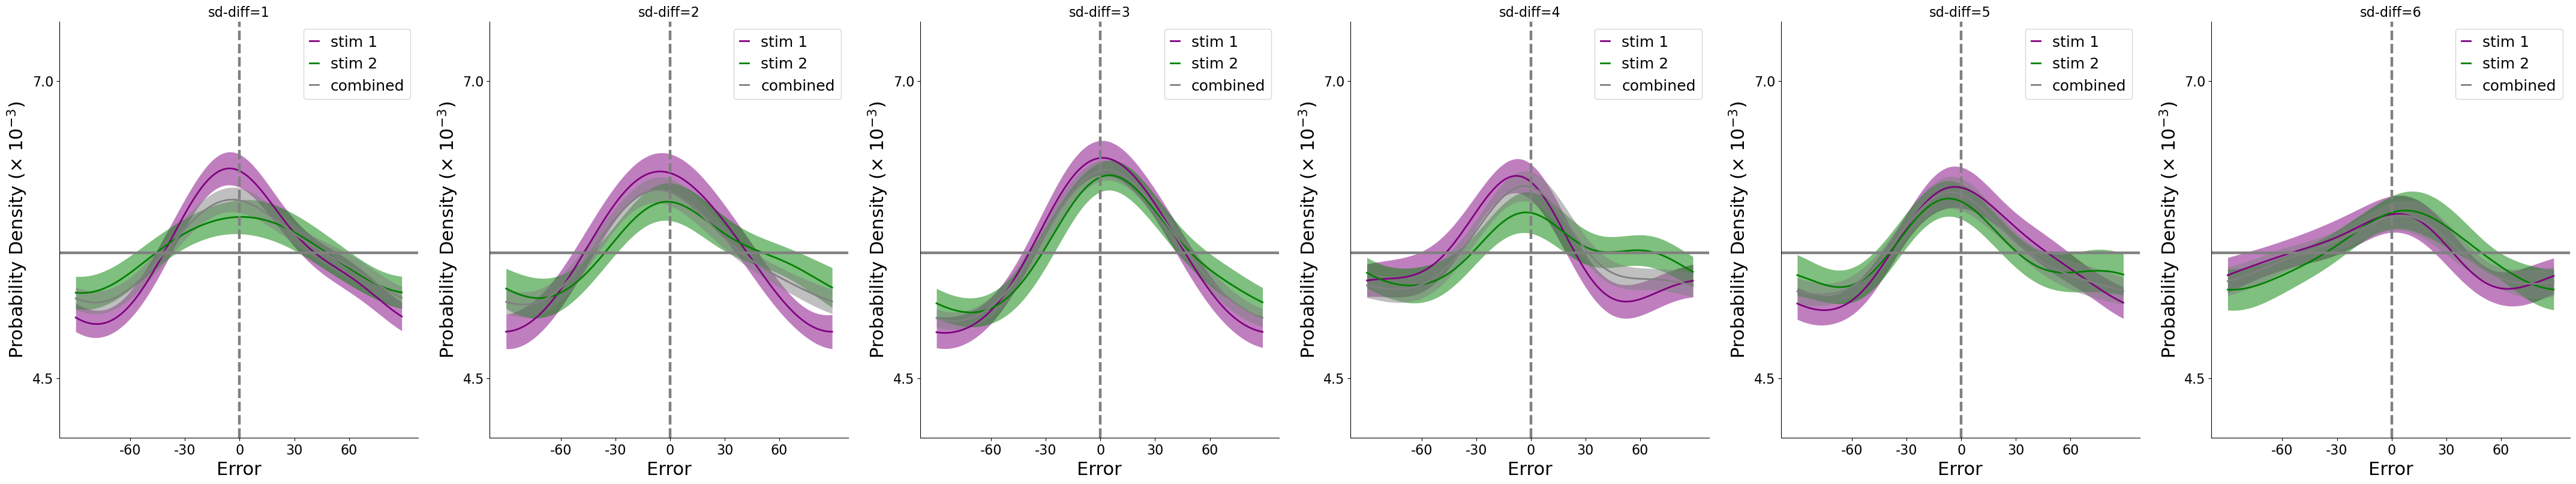

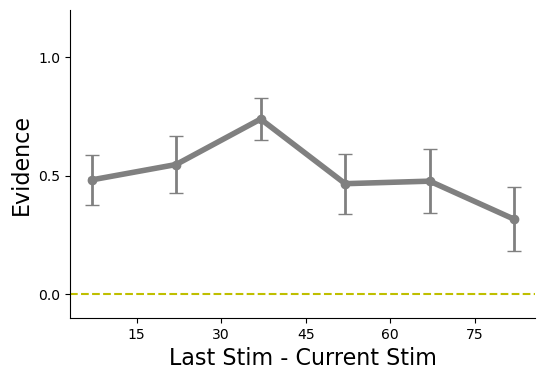

In [71]:
stats = display_stats_as_tuning_func_of_sd_diff(
    full_delay_phase_results, 'accuracy', common_lmb=None, plot_name='')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
display_stats_as_tuning_func_of_sd_diff_compact(ax, stats, 'accuracy', plot_color='gray')

if TO_USE_PREV_STIM:
    ax.set_xlabel('Last Stim - Current Stim', fontsize=16)

In [72]:
has_prev_lmb = lambda d: (d['prev_last_response'].notna()).values

0.39008009823252043
0.8951288817586063
0.8711869408608133
0.5739972120463683
0.7720292841649632
0.3723358775905865


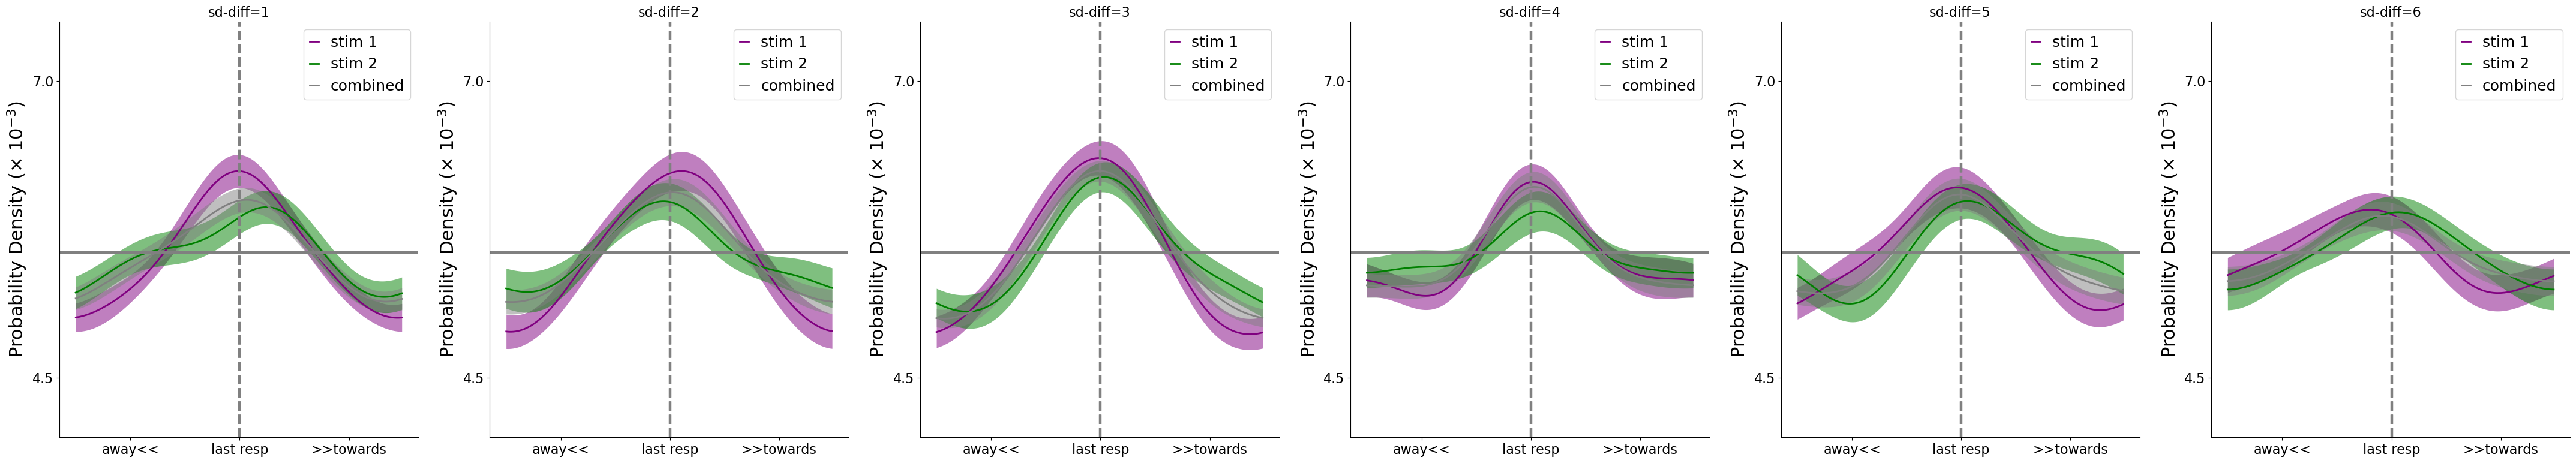

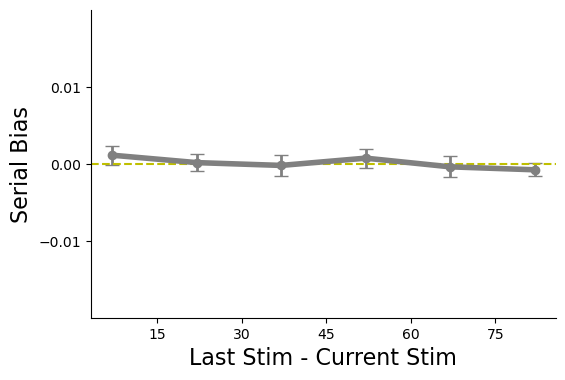

In [73]:
stats = display_stats_as_tuning_func_of_sd_diff(
    full_delay_phase_results, 'sd', common_lmb=has_prev_lmb, plot_name='')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
display_stats_as_tuning_func_of_sd_diff_compact(ax, stats, 'sd', plot_color='gray')

if TO_USE_PREV_STIM:
    ax.set_xlabel('Last Stim - Current Stim', fontsize=16)

### Compare: combine everything?

### Compare behavior

In [74]:
from utils.behav_analysis_helper import subj_behav_df_to_stats
import scipy.stats as scipy_stats

def fetch_behavior_as_tuning_func_of_sd_diff(
        results, stats_type, common_lmb=None):
    all_cond_stats = []
    for sd_bin_id in np.arange(N_SD_BINS):
        sd_bin_val = sd_bin_id / N_SD_BINS 
        sd1_lmb = lambda d: (
            (d['sd_diff_group_1'] == sd_bin_val)
        ).values
        sd2_lmb = lambda d: (
            (d['sd_diff_group_2'] == sd_bin_val)
        ).values
        sd_valid_lmb = None
        if common_lmb is not None:
            sd_valid_lmb = lambda d: (
                common_lmb(d) & (sd1_lmb(d) | sd2_lmb(d)))
        else:
            sd_valid_lmb = lambda d: (
                (sd1_lmb(d) | sd2_lmb(d)))
        
        # collect each subject stats
        sd_bin_stats = []
        for _, subj_df in results['test_df'].groupby('participant'):
            subj_stats = subj_behav_df_to_stats(
                subj_df, lmb=sd_valid_lmb, 
                stim1_lmb=sd1_lmb, 
                stim2_lmb=sd2_lmb, 
                stat_type=stats_type)
            if subj_stats is not None:
                sd_bin_stats.append(subj_stats)

        # compute summary stats
        t_stat, p_val = scipy_stats.ttest_1samp(sd_bin_stats, 0)
        bin_sum_stats = {
            'mean': np.mean(sd_bin_stats),
            'sem': np.std(sd_bin_stats) / np.sqrt(len(sd_bin_stats)),
            'p_val': p_val,
            't_stat': t_stat,
        }

        # collect the stats
        stat_name = {
            'accuracy': 'accuracy',
            'sd': 'bias'
        }[stats_type]
        bin_stats_reformatted = {
            'combined': {
                stat_name: bin_sum_stats,
            }
        }
        all_cond_stats.append(bin_stats_reformatted)

    return all_cond_stats

In [75]:
behav_sd_stats_delay_summary = fetch_behavior_as_tuning_func_of_sd_diff(
    full_delay_phase_results, 'sd', common_lmb=has_prev_lmb)

0.44222352692168243
0.050215607899184944
0.02019752452313892
0.12801103335100508
0.07575992613389215
0.34960986608412636


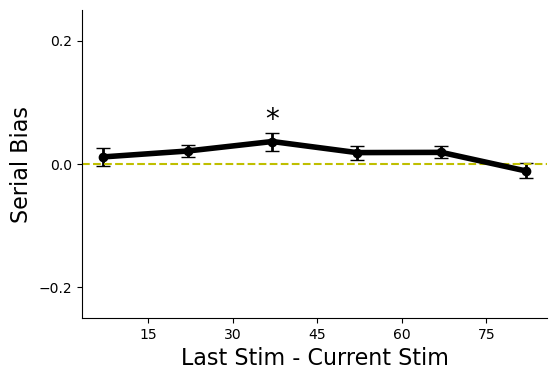

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
display_stats_as_tuning_func_of_sd_diff_compact(
    ax, behav_sd_stats_delay_summary, 'sd', mark_sig_offset=0.5, plot_color='black')
ax.set_ylim([-0.25, 0.25])
ax.set_yticks([-0.2, 0, 0.2])

if TO_USE_PREV_STIM:
    ax.set_xlabel('Last Stim - Current Stim', fontsize=16)

### compare gaze

In [78]:
DEFAULT_FEATURE_CONVERSION = {
    '1d': {
        'old': np.arange(2, 32),
        'zoom_ratio': 1.0,
    },   
    '2d': {
        'old': np.arange(32, 32+d2_H*d2_W),
        'H': d2_H,
        'W': d2_W,
        'zoom_ratio': 0.4,
    },
}

In [79]:
DEFAULT_FORWARD_MODEL_PARAMS = {
    'init': {
        'feature_conversion_params': DEFAULT_FEATURE_CONVERSION,
        'n_channels': DEFAULT_N_CHANNELS,
    },
    'forward': {
        'sharpness': delay_best_sharpness,
    }
}

In [80]:
model_params = DEFAULT_FORWARD_MODEL_PARAMS

full_delay_phase_results = cv_train_test_invert_encoding(
    model_params, 
    delay_phase, delay_phase, 
    ['stim_1', 'stim_2'], ['stim_1', 'stim_2'], 
    None, None,
    item_weights_lmb, n_subjects)

delay_model = ForwardModel(
    **model_params['init'])
delay_sharpness = model_params['forward']['sharpness']

0.9659608723279902
0.9588508613705029
0.6839064501544159
0.8608319748972584
0.18930969071871986
0.8707360358031881


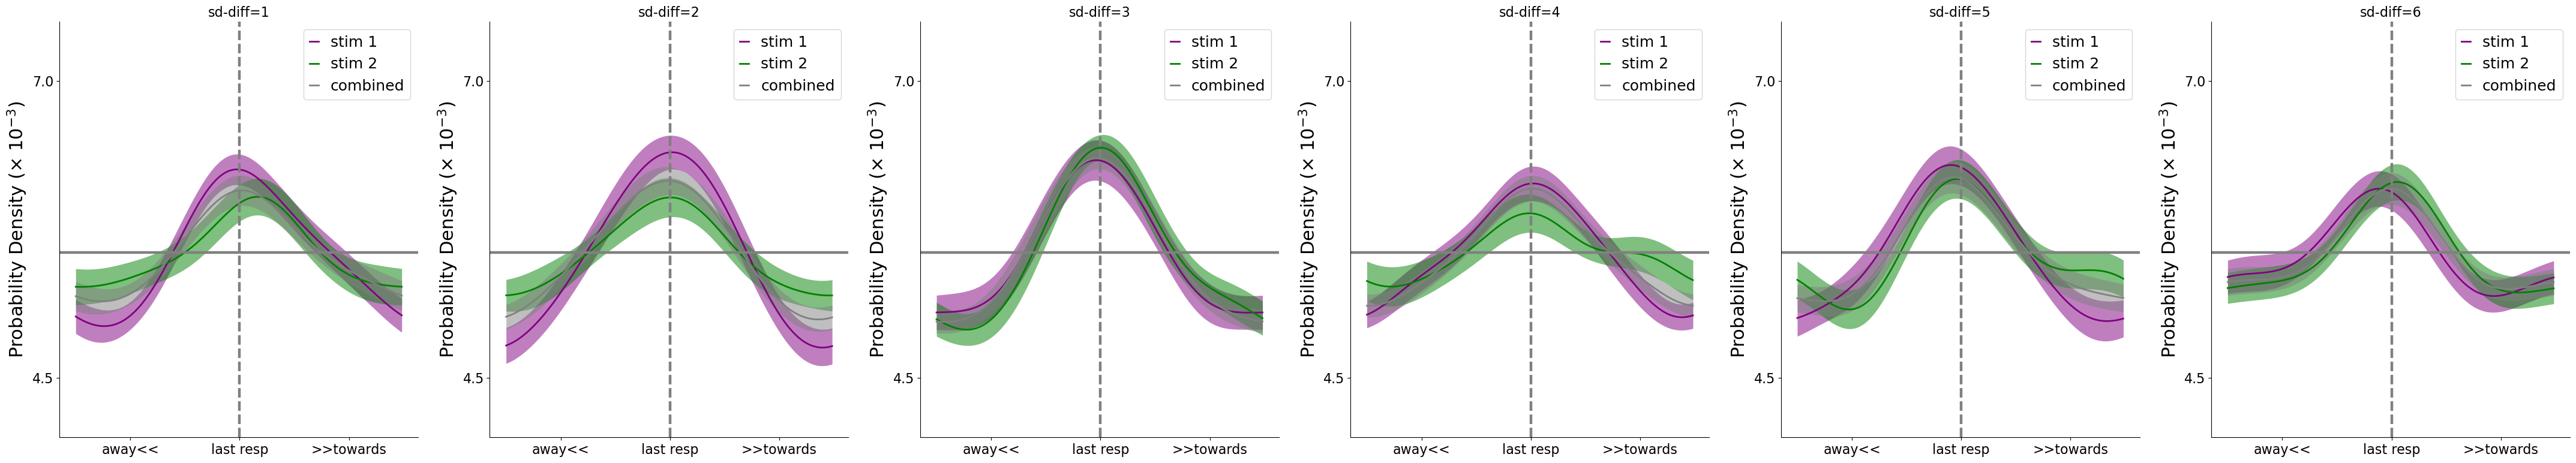

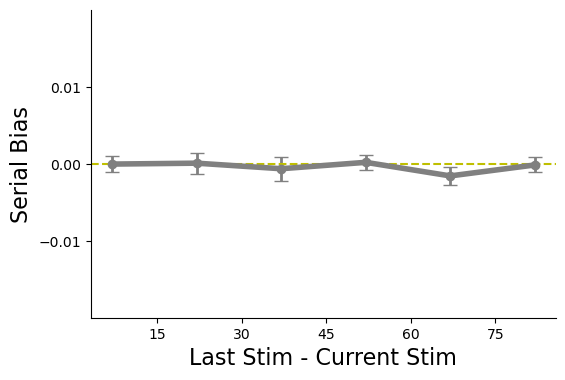

In [81]:
stats = display_stats_as_tuning_func_of_sd_diff(
    full_delay_phase_results, 'sd', common_lmb=has_prev_lmb, plot_name='')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
display_stats_as_tuning_func_of_sd_diff_compact(ax, stats, 'sd', plot_color='gray')

if TO_USE_PREV_STIM:
    ax.set_xlabel('Last Stim - Current Stim', fontsize=16)

**comment**: sd effect disappears if we use previous stim?